# Graph net for link prediction

Question: does including the neighborhood provide a benefit over the pairwise classification?

In [1]:
import numpy as np
import torch
import sys

import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

import torch_geometric.nn as gnn

from reco.model import DynamicEdgeConvBlock

from reco.training import precision_recall_curve, roc_auc
from reco.loss import QualityFocalLoss
from reco.dataset_graph import TracksterGraph


ds_name = "CloseByPion200P"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

data_root = "/mnt/ceph/users/ecuba/processed"
raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=400,
    radius=15,
    bigT_e_th=5,
    link_prediction=True,
    pileup=True,
)
ds

TracksterGraphPU(graphs=7569, nodes=341008, radius=15, bigT_e_th=5, lp)

In [12]:
len(ds.data.y)

729995

In [24]:
ds_size = len(ds)
test_set_size = ds_size // 20
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}, total: {ds_size}")

train_dl = DataLoader(train_set, batch_size=8, shuffle=True, drop_last=True)
test_dl = DataLoader(test_set, batch_size=8, shuffle=True, drop_last=True)

Train graphs: 7191, Test graphs: 378, total: 7569


In [25]:
class LinkPredictionNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.2):
        super(LinkPredictionNet, self).__init__()
        self.norm = gnn.LayerNorm(input_dim)
        
        hdim1 = 32
        hdim2 = 64
        hdim_fc = 128

        self.edgeconv1 = DynamicEdgeConvBlock(input_dim, hdim1, k=8)
        self.edgeconv2 = DynamicEdgeConvBlock(hdim1, hdim2, k=8)
        
        # Edge features from node embeddings for classification        
        self.nodenetwork = nn.Sequential(
            nn.Linear(2 * hdim2, hdim_fc),
            nn.Sigmoid(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, output_dim),
        )

    def forward(self, X, edge_index, batch=None):
        H0 = X #self.norm(X, batch)
        H1 = self.edgeconv1(H0, batch=batch)
        H2 = self.edgeconv2(H1, batch=batch)
        
        H3 = H2

        src, dst = edge_index
        edges = torch.cat([H3[src], H3[dst]], dim=-1)
        return self.nodenetwork(edges).squeeze(-1)

In [26]:
def train_link_prediction(model, device, optimizer, loss_func, train_dl):
    train_loss = []
    model.train()

    for data in train_dl:
        data = data.to(device)
        optimizer.zero_grad()

        seg_pred = model(data.x, data.edge_index, batch=data.batch)        
        loss = loss_func(seg_pred, data.y)
        
        loss.backward()
        
        optimizer.step()
        train_loss.append(loss.item())

    return np.mean(train_loss)

In [27]:
@torch.no_grad()
def test_link_prediction(model, device, loss_func, test_dl):
    test_loss = []
    model.eval()
    for data in test_dl:
        data = data.to(device)
        seg_pred = model(data.x, data.edge_index, data.batch)
        loss = loss_func(seg_pred, data.y)
        test_loss.append(loss.item())

    return np.mean(test_loss)

In [28]:
model = LinkPredictionNet(input_dim=ds.data.x.shape[1])
epochs = 101
model_path = f"models/LinkPredictionNet.PnetL.ns.{epochs}e-{ds_name}.r{ds.RADIUS}.e{ds.bigT_e_th}.f{ds.N_FILES}.pt"

In [29]:
#%%script echo skipping
# alpha - percentage of negative edges
loss_func = QualityFocalLoss()

model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)

for epoch in range(epochs):

    train_loss = train_link_prediction(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    scheduler.step()

    if epoch % 2 == 0:
        test_loss = test_link_prediction(model, device, loss_func, test_dl)
        print(
            f"Epoch {epoch}:\t train loss: {train_loss:.3f}\t validation loss: {test_loss:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)
print(model_path)

Epoch 0:	 train loss: 64.004	 validation loss: 52.243
Epoch 2:	 train loss: 44.874	 validation loss: 46.791
Epoch 4:	 train loss: 40.543	 validation loss: 45.314
Epoch 6:	 train loss: 38.907	 validation loss: 43.985
Epoch 8:	 train loss: 37.668	 validation loss: 51.030
Epoch 10:	 train loss: 36.810	 validation loss: 50.124
Epoch 12:	 train loss: 36.358	 validation loss: 49.663
Epoch 14:	 train loss: 35.639	 validation loss: 39.058
Epoch 16:	 train loss: 35.273	 validation loss: 39.405
Epoch 18:	 train loss: 34.547	 validation loss: 39.565
Epoch 20:	 train loss: 34.229	 validation loss: 39.191
Epoch 22:	 train loss: 33.837	 validation loss: 81.096
Epoch 24:	 train loss: 33.530	 validation loss: 40.683
Epoch 26:	 train loss: 33.269	 validation loss: 37.758
Epoch 28:	 train loss: 33.004	 validation loss: 47.886
Epoch 30:	 train loss: 32.742	 validation loss: 37.735
Epoch 32:	 train loss: 32.618	 validation loss: 37.632
Epoch 34:	 train loss: 32.269	 validation loss: 37.850
Epoch 36:	 trai

models/LinkPredictionNet.PnetL.ns.101e-CloseByPion200P.r15.e5.f400.pt


Epoch 100:	 train loss: 28.649	 validation loss: 35.964


In [30]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


0.932794292424757


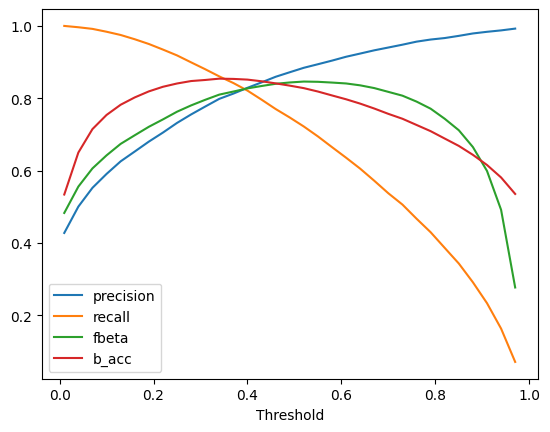

TP: 11683, TN: 21609, FP: 1533, FN: 4503
TH: 0.52 precision: 0.884 recall: 0.722 fbeta: 0.846 b_acc: 0.828


In [31]:
#%%script echo skipping
print(roc_auc(model, device, test_dl))
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=3, truth_threshold=0.5)

## Eval

In [32]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import model_evaluation
from reco.dummy import DummyPleaser

file_name = f"{raw_dir}/new_ntuples_15643817_2.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name, pileup=True)

In [33]:
r_ranges = [3, 5, 10, 15]
results = []

max_events = 20
clue3D_F = []
target_F = []
model_reco_F = []
for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")
    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model.to("cpu"),
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        bigT_e_th=5,
        pileup=True,
        graph=True,
        link_prediction=True,
    )
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

 --- Radius threshold: 3 ---
Event 0:
	clue3d_to_sim:	P: 0.836 R: 0.298 F: 0.614
	target_to_sim:	P: 0.818 R: 0.347 F: 0.643
	reco_to_sim:	P: 0.825 R: 0.347 F: 0.647
	|S| = 1 |T| = 2 |R| = 2
Event 1:
	No data
Event 2:
	clue3d_to_sim:	P: 0.970 R: 0.215 F: 0.569
	target_to_sim:	P: 0.971 R: 0.260 F: 0.627
	reco_to_sim:	P: 0.971 R: 0.260 F: 0.627
	|S| = 1 |T| = 2 |R| = 2
Event 3:
	No data
Event 4:
	No data
Event 5:
	No data
Event 6:
	clue3d_to_sim:	P: 0.971 R: 0.499 F: 0.816
	target_to_sim:	P: 0.964 R: 0.524 F: 0.825
	reco_to_sim:	P: 0.971 R: 0.501 F: 0.818
	|S| = 1 |T| = 4 |R| = 4
Event 7:
	clue3d_to_sim:	P: 0.890 R: 0.022 F: 0.100
	target_to_sim:	P: 0.902 R: 0.023 F: 0.105
	reco_to_sim:	P: 0.902 R: 0.023 F: 0.105
	|S| = 1 |T| = 2 |R| = 2
Event 8:
	clue3d_to_sim:	P: 0.881 R: 0.306 F: 0.640
	target_to_sim:	P: 0.867 R: 0.408 F: 0.708
	reco_to_sim:	P: 0.881 R: 0.399 F: 0.710
	|S| = 1 |T| = 1 |R| = 1
Event 9:
	clue3d_to_sim:	P: 0.994 R: 0.095 F: 0.343
	target_to_sim:	P: 0.995 R: 0.138 F: 0.444

In [34]:
print("CLUE:", clue3D_F)
print("Target:", target_F)
print("Reco:", model_reco_F)

CLUE: [0.2660786195101392, 0.5618487610549607, 0.6503284712982198, 0.6974920132483364]
Target: [0.2925245062036259, 0.631796889255891, 0.7530917443918212, 0.8020145508567055]
Reco: [0.28307734475674334, 0.616571273678623, 0.7505698827151652, 0.7948727273697329]


NameError: name 'naive_reco_F' is not defined

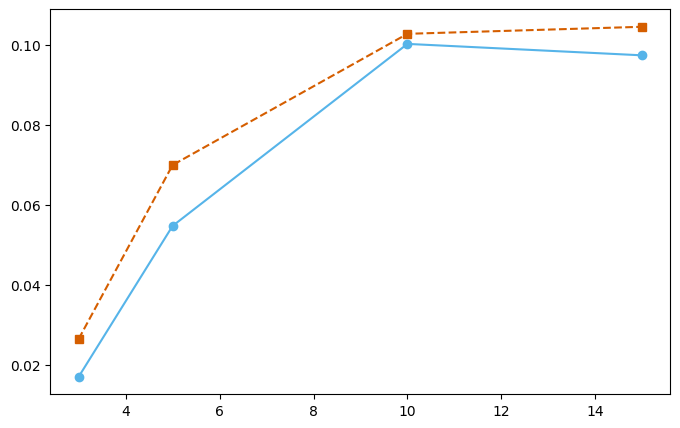

In [35]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(r_ranges[:6], (np.array(target_F) - np.array(clue3D_F))[:6], '--s', label="target $\Delta F_{0.5}$", c="#D55E00")
ax.plot(r_ranges[:6], (np.array(model_reco_F) - np.array(clue3D_F))[:6], '-o', label="GNN LP $\Delta F_{0.5}$", c="#56B4E9")
# ax.plot(r_ranges[:6], (np.array(naive_reco_F) - np.array(clue3D_F))[:6], '-v', label="naive $\Delta F_{0.5}$", c="#E69F00")

ax.axhline(max(np.array(naive_reco_F) - np.array(clue3D_F)), label="baseline", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")
ax.set_ylim((-0.1, 0.1))

fig.savefig(f'export/{ds_name}-e5-graph-lp-de-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
print("Reco", max(np.array(model_reco_F) - np.array(clue3D_F)))
print("Naive", max(np.array(naive_reco_F) - np.array(clue3D_F)))
print("Target", max(np.array(target_F) - np.array(clue3D_F)))

## Setup comparison:

Pairwise:
- mean clue3d_to_sim:	P: 0.994 R: 0.301 F: 0.652
- mean target_to_sim:	P: 0.992 R: 0.689 F: 0.892
- mean reco_to_sim:	    P: 0.659 R: 0.699 F: 0.642

Graph (node-pred):
- mean clue3d_to_sim:	P: 0.994 R: 0.301 F: 0.652
- mean target_to_sim:	P: 0.992 R: 0.688 F: 0.892
- mean reco_to_sim:	    P: 0.659 R: 0.699 F: 0.642

Graph (link-pred):
- mean clue3d_to_sim:	P: 0.994 R: 0.301 F: 0.652
- mean target_to_sim:	P: 0.992 R: 0.689 F: 0.892
- mean reco_to_sim:	P: 0.915 R: 0.329 F: 0.637


## Results

Using alpha=balance seems to converge faster (100 epochs rather than 200)
- maybe just sticking to 0.25? (works just fine)

Hyperparams
- (64, 128, noskip), alpha=balance, roc_auc = 0.9733
- (64, 128, 256fc, noskip, 200e), alpha=1-balance, roc_auc = 0.9771
- (64, 128, 256fc, noskip, 200e), alpha=balance, roc_auc = 0.981
- (64, 128, 256fc, noskip, 100e), alpha=0.25, roc_auc = 0.9796